In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

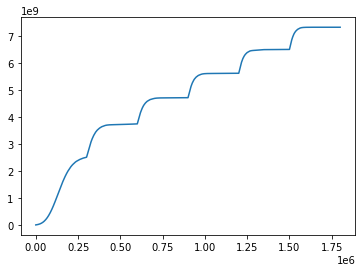

In [2]:
#Importing the different data options
ice=pd.read_csv("../ice_dimensions_b_0.006.csv") # Glacier length - less precise
mass=pd.read_csv("../ice_m_b_0.006.csv") # Glacier mass - more precise

plt.plot(mass['0'])

In [3]:
def min_max_scaling(data):
    # Normalize data (used in an older version of the script)
    data_2= (data - np.min(data)) / (np.max(data) - np.min(data))
        
    return data_2

def closest(list, Number):
    # Find the closest value in list to Number - caution, if more than one x value for every y value,
    # can cause problems and pick the wrong one - adjust accordingly.
    aux = []
    for valor in list:
        aux.append(abs(Number-valor))

    return aux.index(min(aux))

In [4]:
def resp_time(data,num,diff,ts,mode):
    #From given data, find the response time for num different ELA jumps (separated by an adjustment time of diff), 
    #with ts timesteps per year, and direction of mass change (up/down) given by mode. Set up to not give the first rt,
    #as going from 0 to equilibrium is often not accurate.
    #Inputs:
    # - Data: list of data
    # - num: number of shifts in equilibrium level
    # - diff: time difference (years) between shifts of equilibrium level
    # - ts: numer of timesteps per year
    # - mode: whether data shows an upwards or downwards mass change (corresponding to a downwards or upwards ELA shift 
        #- keep it to one way per run, else it gets confused)
        
    eq_levels=[] #Level at which the glacier stabilizes
    rt=np.empty((num,1)) #Response times in number of time steps
    times=np.arange(0,diff*num*ts+1) #index of timesteps
    changes=np.arange(0,diff*num*ts+1,diff*ts) #At which indices the change in ELA occurs
    steps=changes[1:]-1 #Positions at which to take the eq.levels (1 ts before the change)
    ice_h=list(data['0']) #turning the data into a useable list
    e_fold=1-1/np.exp(1) #efolding distance
       
    if mode=="up": #Corresponds to an increasing mass, or decreasing ELA
        
        for i in range(num):#first grab the equil. levels 
            eq_levels=np.append(eq_levels,data['0'][steps[i]])
            
        for j in range(1,num): #process eq.levels 
            mass_diff=eq_levels[j]-eq_levels[j-1] #find diff in mass
            e_fold_m=e_fold*mass_diff+eq_levels[j-1] #find the "e folding mass" (m *0.63) and add to bottom level
            rt[j]=times[closest(ice_h,e_fold_m)]-changes[j] #find time this occurs and subtract time of ELA change
        
    elif mode == "down":# Corresponds to a decreasing mass, or increasing ELA
        
        jump=200000 #increase to prevent improper selection. "jumps" over first section of dataset
        ice_h_d=ice_h[jump:]
        
        for i in range(num):#first grab the equil. levels 
            eq_levels=np.append(eq_levels,data['0'][steps[i]])
            
        for j in range(num-1): #process eq.levels 
            mass_diff=eq_levels[j]-eq_levels[j+1] #find diff in mass
            e_fold_m=eq_levels[j]-e_fold*mass_diff#find the "e folding mass" (m *0.63) and subtract from top level
            rt[j]=times[closest(ice_h_d,e_fold_m)]+jump-changes[j+1] #find time this occurs, subtract time of ELA change
            
    #Testing:
    #print(rt/ts)
    #print(eq_levels) 
    #print(loc_eq_levels)
    #print(changes)
    return eq_levels,rt/ts #returns eq.levels to check with graph above. rt is given in ts, need to divide to get years

In [5]:
eq_levels,rt=resp_time(mass,6,1000,300,'up') 
rts=[]
for i in np.arange(1,len(rt)):
    rts=np.append(rts,rt[i])
print(rts)

[133.38666667 104.16        90.73        84.36333333  75.68      ]
